# Getting Started with the Assistants API

During the public preview, the Assistants API is not available everywhere. Check https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#assistants-preview. I will use Sweden Central.

The API version to use in Azure is 2024-02-15-preview

Let's start creating an Azure OpenAI client...


In [1]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI

# Load environment variables from .env file
# AZURE_OPENAI_API_KEY
# AZURE_OPENAI_ENDPOINT
# AZURE_OPENAI_API_VERSION
load_dotenv()

# Create Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION')
)


## Creating the assistant

In [2]:
assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="""You are a math tutor that helps users solve math problems. 
    You have access to a sandboxed environment for writing and testing code. 
    Explain to the user why you used the code and how it works
    """,
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-preview" # ensure you have a deployment in the region you are using
)

# display information about the assistant
print(assistant.model_dump_json(indent=2))


{
  "id": "asst_B1Vh2TUyS07IPOscaJQ3cPO0",
  "created_at": 1707392440,
  "description": null,
  "file_ids": [],
  "instructions": "You are a math tutor that helps users solve math problems. \n    You have access to a sandboxed environment for writing and testing code. \n    Explain to the user why you used the code and how it works\n    ",
  "metadata": {},
  "model": "gpt-4-preview",
  "name": "Math Tutor",
  "object": "assistant",
  "tools": [
    {
      "type": "code_interpreter"
    }
  ]
}


Above, you can see an assistant has a unique ID. For some reason, you don't see this ID in the Azure OpenAI Playground. With OpenAI, the assistants you create are shown in their portal.

## Creating a thread

Now we can create a thread. A thread is **not linked** to the assistant at creation time

In [3]:
# Create a thread
thread = client.beta.threads.create()

# Threads have an id as well
print("Thread id: ", thread.id)

Thread id:  thread_KV2eD7D8c9dj3mxcSnhHbDIl


## Adding a user question

Now we can add a user question to the thread via a **message**. The message is put on the thread via its ID.

After adding the message, we get the messages from the tread and dump them. Every message has an ID and content. The type of content we add is just text and comes from a user (role=user).

In [4]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Solve the equation y = x^2 + 3 for x = 3 and plot the function graph."
)

# Show the messages
thread_messages = client.beta.threads.messages.list(thread.id)
print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_eJZYxX3aiSHiuuoILnakR78e",
      "assistant_id": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Solve the equation y = x^2 + 3 for x = 3 and plot the function graph."
          },
          "type": "text"
        }
      ],
      "created_at": 1707392448,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "thread_id": "thread_KV2eD7D8c9dj3mxcSnhHbDIl"
    }
  ],
  "object": "list",
  "first_id": "msg_eJZYxX3aiSHiuuoILnakR78e",
  "last_id": "msg_eJZYxX3aiSHiuuoILnakR78e",
  "has_more": false
}


## Running a thread

Adding a message to a thread does not do much. To get a response from the assistant's model, we need to run the thread.

When you run the thread, you can provide extra instructions via the `instructions` parameter. We do not do that below.

A thread is run asychronously. We need to check the run status to see if it is done. After you run the cell below, keep running the cell under it until the status is `completed`. When it is not completed, the status is `in_progress`.

Other statuses: cancelled, expired, failed

In [5]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

In [18]:
# run this until the run is completed
# it can take a while before the run is completed
# in a real application, create a loop that waits for the run to complete
run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)

status = run.status
print(status)

completed


## Result of the run

To see what happened, we have to check the messages of the thread. The user message will be at the bottom. There should be a message with role=assistant. This is the response from the assistant's model. The message has a `content` field with the response. There can be multiple types of responses, for instance text and image.

In [19]:
# dump the messages on the thread again
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_IRjzrfYARoXPOFYEsJyZUVtE",
      "assistant_id": "asst_B1Vh2TUyS07IPOscaJQ3cPO0",
      "content": [
        {
          "image_file": {
            "file_id": "assistant-j4dEFv2ISc57CwRBcblNO5c9"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "To solve the equation \\(y = x^2 + 3\\) for \\(x = 3\\), I first defined a Python function `f(x)` that calculates the value of the equation given x. For \\(x = 3\\), I calculated \\(y\\) using this function, which gave us a value of \\(y = 12\\).\n\nTo illustrate this visually, I then used NumPy and Matplotlib to plot the function graph. I created a range of x values from -10 to 10 using `np.linspace` and calculated the corresponding y values using the function `f(x)`. Then I plotted these values on the graph, resulting in the curve you see.\n\nAdditionally, I included a red point on the graph to indicate where \\(x = 3\

## Showing the response

We can show all messages in the array in reverse order to start from the beginning. Depending on the content (text, image) we can do something with it.

For now just print the text or file_id if there is one

In [20]:
import json

messages_json = json.loads(messages.model_dump_json())

for item in reversed(messages_json['data']):
    # Check the content array
    for content in reversed(item['content']):
        # If there is text in the content array, print it
        if 'text' in content:
            print(content['text']['value'], "\n")
        # If there is an image_file in the content, print the file_id
        if 'image_file' in content:
            print("Image ID:" , content['image_file']['file_id'], "\n")

Solve the equation y = x^2 + 3 for x = 3 and plot the function graph. 

To solve the equation \(y = x^2 + 3\) for \(x = 3\), I first defined a Python function `f(x)` that calculates the value of the equation given x. For \(x = 3\), I calculated \(y\) using this function, which gave us a value of \(y = 12\).

To illustrate this visually, I then used NumPy and Matplotlib to plot the function graph. I created a range of x values from -10 to 10 using `np.linspace` and calculated the corresponding y values using the function `f(x)`. Then I plotted these values on the graph, resulting in the curve you see.

Additionally, I included a red point on the graph to indicate where \(x = 3\) lies on the function. This point, marked on the graph, is at the coordinates (3, 12), in line with our calculation.

The final plot accurately represents the function \(y = x^2 + 3\), and clearly shows the solution to the equation for \(x = 3\). This visual representation assists in understanding not just the sp

## Retrieving the image file

Same code as above but show the image with PIL and IPython.display

Solve the equation y = x^2 + 3 for x = 3 and plot the function graph. 

To solve the equation \(y = x^2 + 3\) for \(x = 3\), I first defined a Python function `f(x)` that calculates the value of the equation given x. For \(x = 3\), I calculated \(y\) using this function, which gave us a value of \(y = 12\).

To illustrate this visually, I then used NumPy and Matplotlib to plot the function graph. I created a range of x values from -10 to 10 using `np.linspace` and calculated the corresponding y values using the function `f(x)`. Then I plotted these values on the graph, resulting in the curve you see.

Additionally, I included a red point on the graph to indicate where \(x = 3\) lies on the function. This point, marked on the graph, is at the coordinates (3, 12), in line with our calculation.

The final plot accurately represents the function \(y = x^2 + 3\), and clearly shows the solution to the equation for \(x = 3\). This visual representation assists in understanding not just the sp

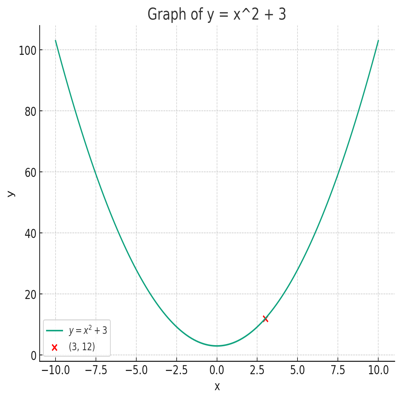

In [21]:
from PIL import Image
from IPython.display import display

for item in reversed(messages_json['data']):
    # Check the content array
    for content in reversed(item['content']):
        # If there is text in the content array, print it
        if 'text' in content:
            print(content['text']['value'], "\n")
        # If there is an image_file in the content, print the file_id
        if 'image_file' in content:
            file_id = content['image_file']['file_id']
            file_content = client.files.content(file_id)
            # use PIL with the file_content
            img = Image.open(file_content)
            img = img.resize((400, 400))
            display(img)
            
            


## Ask another question

We can add another user message to the thread and run it again. But now, we will wait for the response and display it right away.

We will use Markdown to display the assistant's response.

The new_run function is a helper function to add a question 

In [31]:
from IPython.display import clear_output, display, Markdown
import time

def new_run(question, thread_id):

    # add new message to the thread
    message = client.beta.threads.messages.create(
        thread_id=thread_id,
        role="user",
        content=question
    )

    # run the tread again
    run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
    )

    status = run.status

    while status not in ["completed", "cancelled", "expired", "failed"]:
        time.sleep(2)
        run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
        status = run.status
        print(f'Status: {status}')
        clear_output(wait=True)

    print(f'Status: {status}')

    messages = client.beta.threads.messages.list(
    thread_id=thread.id
    )

    messages_json = json.loads(messages.model_dump_json())

    for item in reversed(messages_json['data']):
        # Check the content array
        for content in reversed(item['content']):
            # If there is text in the content array, print it as Markdown
            if 'text' in content:
                display(Markdown(content['text']['value']))
            # If there is an image_file in the content, print the file_id
            if 'image_file' in content:
                file_id = content['image_file']['file_id']
                file_content = client.files.content(file_id)
                # use PIL with the file_content
                img = Image.open(file_content)
                img = img.resize((400, 400))
                display(img)

new_run("Plot a sine wave from 0 to 2π.", thread)

AttributeError: 'Threads' object has no attribute 'list'